In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch
import os
import sys
sys.path.append("../")
from dynaprot.evaluation.visualizer import plot_3d_gaussian_ellipsoids,plot_3d_gaussian_comparison
import plotly.express as px
import matplotlib.pyplot as plt



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data_dir = "/data/cb/scratch/datasets/atlas_dynamics_labels_replicates"
data_config_dir = "../configs/data"
config_dir = "../configs"

In [21]:
import yaml
from pathlib import Path

# Load data config
with open(config_dir+"/data/atlas_config.yaml", "r") as file:
    dataconfig = yaml.safe_load(file)
    
# Load train config
with open(config_dir+"/model/dynaprot_simple.yaml", "r") as file:
    modelconfig = yaml.safe_load(file)
    
modelconfig["data_config"] = dataconfig
    
print(modelconfig)

from dynaprot.data.datasets import DynaProtDataset, OpenFoldBatchCollator

dataset = DynaProtDataset(dataconfig)

dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=1,
        collate_fn=OpenFoldBatchCollator(),
        num_workers=12,
        shuffle=False,
    )
batch_prots = next(iter(dataloader))

for k in batch_prots.keys():
    # print(k,batch_prots[k])
    print(f"{k}: {batch_prots[k].shape}")

{'model_params': {'num_ipa_blocks': 8, 'd_model': 128}, 'train_params': {'precision': 32, 'batch_size': 20, 'epochs': 10000, 'learning_rate': 0.0001, 'warmup_steps': 2000, 'total_steps': 20000, 'grad_clip_norm': 1.0, 'accelerator': 'gpu', 'strategy': 'ddp', 'num_devices': [1, 2, 3, 4, 5], 'num_nodes': 1, 'project': 'openprot/dynamics', 'neptune_api_key': 'INSERT YOUR API TOKEN HERE', 'tags': ['dynaprot', 'debugging', 'dropout'], 'log_model_checkpoints': True}, 'eval_params': {'loss_weights': {'resi_gaussians': {'mse_means': 0.0, 'mse_covs': 0.0, 'kldiv': 0.0, 'eigen_penalty': None, 'cond_penalty': None, 'frob_norm': 0.0, 'log_frob_norm': 0.0, 'affine_invariant_dist': 0.0, 'bures_dist': 1.0}, 'resi_rmsf': None, 'resi_rmsd': None, 'resi_rg': None}}, 'checkpoint_path': '', 'logs': '/path/to/logs', 'results': '/path/to/results', 'data_config': {'repo_dir': '/data/cb/mihirb14/projects/DynaProt', 'data_dir': '/data/cb/scratch/datasets/atlas_dynamics_labels_calpha', 'protein_chains_path': '/d

aatype: torch.Size([1, 512, 21])
residue_index: torch.Size([1, 512])
all_atom_positions: torch.Size([1, 512, 37, 3])
all_atom_mask: torch.Size([1, 512, 37])
frames: torch.Size([1, 512, 4, 4])
dynamics_means: torch.Size([1, 512, 3])
dynamics_covars: torch.Size([1, 512, 3, 3])
dynamics_fullcovar: torch.Size([1, 512, 512])
dynamics_correlations: torch.Size([1, 512, 512])
resi_pad_mask: torch.Size([1, 512])


In [23]:
from dynaprot.model.architecture import DynaProt

model = DynaProt(cfg=modelconfig)
model

DynaProt(
  (sequence_embedding): Embedding(21, 128)
  (ipa_blocks): ModuleList(
    (0-7): 8 x InvariantPointAttention(
      (linear_q): Linear(in_features=128, out_features=64, bias=True)
      (linear_kv): Linear(in_features=128, out_features=128, bias=True)
      (linear_q_points): Linear(in_features=128, out_features=48, bias=True)
      (linear_kv_points): Linear(in_features=128, out_features=144, bias=True)
      (linear_b): Linear(in_features=128, out_features=4, bias=True)
      (linear_out): Linear(in_features=704, out_features=128, bias=True)
      (softmax): Softmax(dim=-1)
      (softplus): Softplus(beta=1, threshold=20)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (covars_predictor): Linear(in_features=128, out_features=6, bias=True)
  (loss): DynaProtLoss()
)

### Check lr scheduler (linear warmup + cosine annealing)

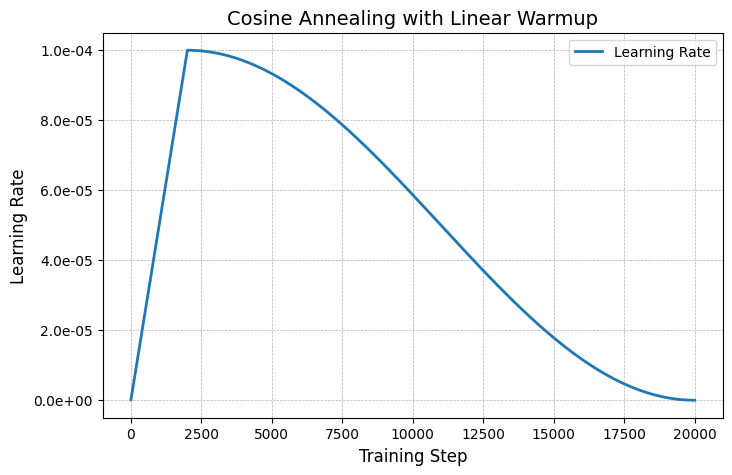

In [24]:
import torch.optim as optim
import matplotlib.ticker as ticker

schedule_dict = model.configure_optimizers()
optimizer, scheduler =  schedule_dict["optimizer"], schedule_dict["lr_scheduler"]

lrs = []
steps = list(range(20000))
for step in steps:
    scheduler.step()
    lrs.append(optimizer.param_groups[0]['lr'])

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(steps, lrs, label="Learning Rate", linewidth=2)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:.1e}"))

ax.set_xlabel("Training Step", fontsize=12)
ax.set_ylabel("Learning Rate", fontsize=12)
ax.set_title("Cosine Annealing with Linear Warmup", fontsize=14)
ax.legend()
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

In [ ]:
model.training_step(batch_prots,0)

In [ ]:
# import torch
# from torch.utils.data import DataLoader

# def calculate_metrics(dataset, batch_size=16, device="cpu"):
#     """
#     Calculate the condition numbers and min/max eigenvalues of ground truth covariance matrices.
    
#     Args:
#         dataset (torch.utils.data.Dataset): Dataset containing ground truth covariance matrices.
#         batch_size (int): Batch size for DataLoader.
#         device (str): Device to run the calculations ('cpu' or 'cuda').
    
#     Returns:
#         dict: Dictionary containing condition numbers, min eigenvalues, and max eigenvalues.
#     """
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=OpenFoldBatchCollator())
#     condition_numbers = []
#     min_eigenvalues = []
#     max_eigenvalues = []

#     for batch in dataloader:
#         # Assuming `batch` contains covariance matrices as a tensor of shape (N, d, d)
#         mask = batch["resi_pad_mask"].bool()
#         ground_truth_covars = batch["dynamics_covars"][mask].to(device)  # Replace "covariances" with your key
#         eigenvalues = torch.linalg.eigvalsh(ground_truth_covars)  # Shape: (N, d)

#         # Compute min, max eigenvalues and condition numbers
#         min_eigenvalues.extend(eigenvalues.min(dim=-1).values.cpu().tolist())
#         max_eigenvalues.extend(eigenvalues.max(dim=-1).values.cpu().tolist())
#         condition_numbers.extend((eigenvalues.max(dim=-1).values / eigenvalues.min(dim=-1).values).cpu().tolist())

#     # Aggregate results
#     metrics = {
#         "condition_numbers": condition_numbers,
#         "min_eigenvalues": min_eigenvalues,
#         "max_eigenvalues": max_eigenvalues,
#     }
#     return metrics

# eigenvalue_metrics = pd.DataFrame(calculate_metrics(dataset))
# eigenvalue_metrics

In [ ]:
eigenvalue_metrics.max_eigenvalues.min()

In [ ]:
import plotly.express as px
px.histogram(eigenvalue_metrics, x="condition_numbers", cumulative=True)

In [ ]:
px.histogram(eigenvalue_metrics, x="max_eigenvalues", cumulative=True)

In [ ]:
batch_prots["dynamics_covars"].mean()

In [5]:
from dynaprot.model.architecture import DynaProt
device= "cpu"
# model = DynaProt.load_from_checkpoint("../.neptune/DYNAMICS-126/DYNAMICS-126/checkpoints/step13112.ckpt", cfg=modelconfig).to(device)
model = DynaProt.load_from_checkpoint("../.neptune/DYNAMICS-126/DYNAMICS-126/checkpoints/step=174798.ckpt", cfg=modelconfig).to(device)

model

DynaProt(
  (sequence_embedding): Embedding(21, 128)
  (ipa_blocks): ModuleList(
    (0-7): 8 x InvariantPointAttention(
      (linear_q): Linear(in_features=128, out_features=64, bias=True)
      (linear_kv): Linear(in_features=128, out_features=128, bias=True)
      (linear_q_points): Linear(in_features=128, out_features=48, bias=True)
      (linear_kv_points): Linear(in_features=128, out_features=144, bias=True)
      (linear_b): Linear(in_features=128, out_features=4, bias=True)
      (linear_out): Linear(in_features=704, out_features=128, bias=True)
      (softmax): Softmax(dim=-1)
      (softplus): Softplus(beta=1, threshold=20)
    )
  )
  (covars_predictor): Linear(in_features=128, out_features=6, bias=True)
  (loss): DynaProtLoss()
)

In [6]:
from openfold.utils.rigid_utils import  Rigid

sample_protein = batch_prots
preds = model(sample_protein["aatype"].argmax(dim=-1).to(device), Rigid.from_tensor_4x4(sample_protein["frames"].to(device)), sample_protein["resi_pad_mask"].to(device))

# plot_3d_gaussian_ellipsoids(sample_protein["dynamics_means"].numpy().squeeze()[:20], sample_protein["dynamics_covars"].numpy().squeeze()[:20], num_points=50, save_path = "./ground_truth.html")
# plot_3d_gaussian_ellipsoids(sample_protein["dynamics_means"].detach().numpy().squeeze()[:20], preds["covars"].detach().numpy().squeeze()[:20], num_points=50, save_path = "./predicted.html")
plot_3d_gaussian_comparison(sample_protein["dynamics_means"].detach().numpy().squeeze()[:50], sample_protein["dynamics_covars"].numpy().squeeze()[:50],  preds["covars"].detach().numpy().squeeze()[:50], num_points=50)

3D Gaussian comparison plot saved to ./ellipsoid_comparison.html


In [42]:
sample_protein["dynamics_means"].detach().numpy().squeeze()[:20].shape
sample_protein["dynamics_covars"].numpy().squeeze()[:20].shape
preds["covars"].detach().numpy().squeeze()[:20].shape

(20, 3, 3)

In [ ]:
model.training_step(batch_prots,0)

In [ ]:
import torch.nn.functional as F
b = 10
n = 2
preds = torch.repeat_interleave(torch.arange(6)+1,n).reshape(-1,n).T.unsqueeze(0).repeat(b,1,1)
# print(preds,preds.shape)


L = torch.zeros(b,n,3,3)

i = 0
for c in range(3):
    for r in range(c,3):
        L[:,:,r,c] = preds[:,:,i] 
        if r == c:
            L[:,:,r,c] = F.softplus(L[:,:,r,c])
        i+=1

covars = L @ L.transpose(2,3)
print(covars)
# # print(L)
# print(covars)